In [3]:
from importlib.metadata import version

import tiktoken
import torch
import tensorflow as tf
import matplotlib
import torch.nn as nn
import torch.nn.functional as F

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))
print("tensorflow version:", version("tensorflow"))
print("matplotlib version:", version("matplotlib"))

torch version: 2.3.1
tiktoken version: 0.7.0
tensorflow version: 2.16.1
matplotlib version: 3.9.0


# 一、 文本数据处理

- 本章介绍数据准备和采样，以便为LLM“准备”输入数据

![Alt text](../../img/LLM/ch01/LLM_Course_pipeline.png)

## 1.1 理解word embeddings

- embedding有多种形式,视频、文字以及语音的embedding

![Alt text](../../img/LLM/ch01/forms_of_embedding.png)

- 这里我们先只关注文本的embedding
- LLM使用的是高维空间的embedding向量,我们用一个二维嵌入来可视化一下这个高维空间

![Alt text](../../img/LLM/ch01/high_dimensional_space.png)

## 1.2 Tokenizer Text

- 在本节中,将文本分解为更小的单元,并将其转换为计算机可识别的id

![Alt text](../../img/LLM/ch01/tokenize_text.png)

In [4]:
import os
import urllib.request

if not os.path.exists("../../Data/the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)
    
with open("../../Data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print(f"Total number of article: {len(raw_text)}")
print(raw_text[:99])

Total number of article: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


- tokenize 文本, 并且进行预处理

In [5]:
import re

text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


![Alt text](../../img/LLM/ch01/tokenization_of_raw_text.png)

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 1.3 将tokens转换为token ID

- 接下来,将文本tokens转换为token IDs,以便于之后我们可以通过embedding层对其进行处理

![Alt text](../../img/LLM/ch01/token_2_tokenID.png)

- 从这些tokens,我们现在可以构建一个包括所有tokens的词表

In [7]:
# 去重
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

# 构建词表
vocab = {token:integer for integer, token in enumerate(all_words)}

for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 30:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)


In [8]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        '''
        Tokenizer 类
        :param vocab: 词表 
        '''
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
        
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

![Alt text](../../img/LLM/ch01/encode_decode.png)

- 我们可以用tokenizer类将文本转换为整数,这些整数可以作为LLM的embedding层输入

In [9]:
tokenizer = SimpleTokenizerV1(vocab)

text = "It's the last he painted, you know, Mrs. Gisburn said with pardonable pride."

ids = tokenizer.encode(text)
print(ids)
decode_text = tokenizer.decode(ids)
print(decode_text)

[56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 67, 7, 38, 851, 1108, 754, 793, 7]
It' s the last he painted, you know, Mrs. Gisburn said with pardonable pride.


## 1.4 特殊文本tokens

- 为未知单词添加一些“特殊”标记并表示文本的结尾是很有用的

![Alt text](../../img/LLM/ch01/special_token.png)

- 一些 tokenizer 使用特殊的 tokens 来帮助LLM提供额外的上下文
- 其中一些特殊 tokens 是
    - [BOS]（序列的开始）标记文本的开始
    - [EOS]（序列结束）标记文本的结束位置（这通常用于连接多个不相关的文本，例如，两篇不同的维基百科文章或两本不同的书，等等）
    - [PAD]（填充）如果我们训练批量大小大于1的LLM（我们可能包括多个不同长度的文本；使用填充 token，我们将较短的文本填充到最长的长度，使所有文本的长度相等）
    - [UNK]表示未包含在词汇表中的词汇
- 请注意，GPT-2不需要上述任何tokens，而只使用<|endoftext|> token 来降低复杂性
    - <|endoftext|>类似于上面提到的[EOS] token
- GPT还使用<|endoftext|>进行填充 (因为我们在对批处理输入进行训练时通常使用掩码，所以无论如何我们都不会使用填充的tokens，所以这些 tokens 是什么并不重要)
- GPT-2不对词汇表外的单词使用<UNK>标记；相反，GPT-2使用了一个字节对编码（BPE）标记器，它将字分解为子字单元，我们将在后面的部分中讨论

![Alt text](../../img/LLM/ch01/endoftext_example.png)

In [10]:
tokenizer = SimpleTokenizerV1(vocab)

text = ("Hello, do you like tea. Is this-- a test?")

tokenizer.encode(text)

KeyError: 'Hello'

- 由于词汇表中未包含“Hello”一词，因此上述操作会产生错误
- 为了处理这种情况，我们可以向词汇表中添加特殊的标记，如“<|unk|>”，以表示未知单词
- 由于我们已经在扩展词汇表，让我们添加另一个名为“<|endoftext|>”的标记，它在GPT-2训练中用于表示文本的末尾（它也用于连接的文本之间，例如如果我们的训练数据集由多篇文章、书籍等组成）

In [ ]:
# 重新进行预处理
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
# 加入辅助词
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer, token in enumerate(all_tokens)}

class SimpleTokenizerV2:
    def __init__(self, vocab):
        '''
        Tokenizer类 v2
        :param vocab: 词表 
        '''
        self.str_to_int = vocab
        self.int_to_str = {i:s for s, i in vocab.items()}
        
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]
        
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

## 1.5 BytePair编码

- GPT-2使用字节对编码（BPE）作为其标记器
- 它允许模型将不在其预定义词汇表中的单词分解为更小的子单词单元甚至单个字符，使其能够处理词汇表外的单词
- 例如，如果GPT-2的词汇表中没有单词“unfamiliarword”，它可能会将其标记为[“unfam”、“iliar”、“word”]或其他一些子单词细分，这取决于其经过训练的BPE合并
- 原始的BPE标记器可以在这里找到：https://github.com/openai/gpt-2/blob/master/src/encoder.py
- 在本章中，我们将使用OpenAI开源tiktoken库中的BPE标记器，该库在Rust中实现其核心算法，以提高计算性能

![Alt text](../../img/LLM/ch01/BPE_tokenizers.png)

In [11]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [12]:
tokenizer = tiktoken.get_encoding("gpt2")
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
strings = tokenizer.decode(integers)
print("integers= \n", integers)
print("strings= \n", strings)

integers= 
 [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]
strings= 
 Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


## 1.6 滑动窗口数据采样

- 我们训练LLM一次生成一个单词，因此我们希望相应地准备训练数据，其中序列中的下一个单词表示要预测的目标：

![Alt text](../../img/LLM/ch01/sliding_window.png)

- 对于每个文本块，我们需要输入和目标
- 由于我们希望模型预测下一个单词，因此目标是向右移动一个位置的输入

In [13]:
with open("../../Data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
enc_text = tokenizer.encode(raw_text)
print(f"length of data: {len(enc_text)}")

enc_sample = enc_text[50:]
context_size = 4

for i in range(1, context_size + 1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    
    print(context, '------>', desired, ' ' * 10, tokenizer.decode(context), "---->", tokenizer.decode([desired]))

length of data: 5145
[290] ------> 4920             and ---->  established
[290, 4920] ------> 2241             and established ---->  himself
[290, 4920, 2241] ------> 287             and established himself ---->  in
[290, 4920, 2241, 287] ------> 257             and established himself in ---->  a


- 在我们介绍了注意力机制之后，我们将在后面的章节中讨论下一个单词的预测
- 目前，我们实现了一个简单的数据加载器，它在输入数据集上迭代，并返回偏移了一个的输入和目标
- 我们使用滑动窗口方法，将位置更改+1：

![Alt text](../../img/LLM/ch01/sliding_window_example.png)

- 创建数据集和数据加载器，从输入文本数据集中提取块

In [14]:
import torch
from torch.utils.data import DataLoader, Dataset

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        '''
        :param txt: 文本 
        :param tokenizer: tokenizer 
        :param max_length: 滑动窗口最大长度
        :param stride: 滑动补偿
        '''
        self.input_ids = []
        self.tar_ids = []
        
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            tar_chunk = token_ids[i + 1:i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.tar_ids.append(torch.tensor(tar_chunk))
            
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.tar_ids[idx]
    

def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_worker=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=0
    )
    return dataloader

- 让我们针对上下文大小为4的LLM测试批处理大小为1的数据加载器

In [15]:
with open(r"../../Data/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


- 使用等于上下文长度的步幅（此处：4）的示例如下所示：

![Alt text](../../img/LLM/ch01/sliding_window_4_stride.png)

- 我们还可以创建批处理输出
- 请注意，我们在这里增加步长，这样批次之间就不会有重叠，因为更多的重叠可能会导致过拟合增加

In [16]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 1.7 创建token embedding向量

- 数据已经准备好进行LLM
- 但最后让我们使用嵌入层将标记嵌入到连续向量表示中
- 通常，这些嵌入层是LLM本身的一部分，并在模型训练期间进行更新（训练）

![Alt text](../../img/LLM/ch01/GPT_pipeline.png)

- 假设我们有以下四个输入示例，输入ID分别为5、1、3和2 (标记化后):

In [17]:
import torch.nn as nn
input_ids = torch.tensor([2, 3, 5, 1])

vocab_size = 6
output_dim = 3
torch.manual_seed(123)
embedding_layer = nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- 上面的嵌入层方法本质上只是在完全连接层中实现一个热编码器-然后进行矩阵乘法的更有效的方式，这在中的补充代码中进行了描述
- 因为嵌入层只是一种更有效的实现，相当于一个热编码和矩阵乘法方法，所以它可以被视为一个可以通过反向传播优化的神经网络层
- 要将id为3的token转换为三维向量，我们执行以下操作：

In [18]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- 注意,上面是embedding_layer权重矩阵中的第4行
- 要embedding上面的所有四个input_ids值，我们需要进行以下操作

In [19]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- 嵌入层本质上是一种查找操作：

![Alt text](../../img/LLM/ch01/embedding_layer.png)

## 1.8 编码单词位置

- 嵌入层将ID转换为相同的矢量表示，而不考虑它们在输入序列中的位置：

![Alt text](../../img/LLM/ch01/embedding_layer_example.png)

- 位置嵌入与标记嵌入向量相结合，以形成大型语言模型的输入嵌入：

![Alt text](../../img/LLM/ch01/position_embedding.png)

- BytePair编码器的词汇表大小为50257：
- 假设我们想要将输入令牌编码为256维向量表示：

In [20]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = nn.Embedding(vocab_size, output_dim)

- 如果我们从数据加载器中采样数据，我们将每个批次中的token嵌入到256维向量中
- 如果我们有一个批量大小为8，每个有4个token，则会产生一个8 x 4 x 256的张量：

In [21]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [22]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


- GPT-2使用绝对位置嵌入，因此我们只需创建另一个嵌入层：

In [23]:
context_length = max_length
pos_embedding_layer = nn.Embedding(context_length, output_dim)

In [24]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [25]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


在输入处理工作流的初始阶段，输入文本被分割成单独的标记
在该分割之后，这些token被转换为基于预定义词汇表的token ID：

![Alt text](../../img/LLM/ch01/vocabulary_with_GPT_pipeline.png)

# 二、搭建注意力机制

In [26]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.3.1


- 本章涵盖注意力机制，LLM的引擎：

![Alt text](../../img/LLM/ch02/engine_of_LLMs.png)

![Alt text](../../img/LLM/ch02/Attention_Mechanism.png)

## 2.1 长序列建模问题

- 由于源语言和目标语言之间的语法结构不同，逐字翻译文本是不可行的：

![Alt text](../../img/LLM/ch02/word2word.png)

- 在引入Transformer模型之前，编码器-解码器RNN通常用于机器翻译任务
- 在这种设置中，编码器使用隐藏状态（神经网络中的一种中间层）处理源语言中的一系列标记，以生成整个输入序列的压缩表示：

![Alt text](../../img/LLM/ch02/input_series.png)

## 2.2 利用注意力机制捕获数据相关性

- 通过注意力机制，网络的文本生成解码器段能够选择性地访问所有输入token，这意味着在特定输出token的生成中，某些输入token比其他输入token具有更大的意义：

![Alt text](../../img/LLM/ch02/attention_tokens.png)

- Transformer中的自注意是一种技术，旨在通过使序列中的每个位置能够参与并确定同一序列中其他每个位置的相关性来增强输入表示

![Alt text](../../img/LLM/ch02/self-attention.png)

## 2.3 用self-attention的方式处理输入的不同部分

### 2.3.1 一种没有可训练权重的简单自注意力机制

- 本节解释了自我注意力机制的一个非常简化的变体，它不包含任何可训练的权重
- 这纯粹是为了说明，而不是transformers中使用的注意力机制
- 下一节，第3.3.2节，将扩展这种简单的注意力机制，以实现真正的自我注意力机制
- 假设我们得到一个输入序列 $x^{(1)}$ 到 $x^{(n)}$
     - 输入是一个文本（例如，像“你的旅程从第一步开始”这样的句子），它已经被转换为token embedding
     - 例如，$x^{(1)}$是表示单词“Your”的d维向量，依此类推
- 目标：计算上下文向量$z^{(i)}$对于$x^{(1)}$到$x^{(T)}$序列中的$x^{(i)}$($x$和$z$具有相同的尺寸)
     - 上下文矢量$z^{(i)}$是输入$x^{(1)}$到$x^{(T)}$序列的加权和
     - 上下文向量是特定于某个输入的“上下文”
        - 与其将$x^{(1)}$作为任意输入token的占位符，让我们考虑第二个输入$x^{(2)}$
        - 继续一个具体的例子，而不是占位符$z^{(1)}$, 我们考虑第二输出上下文向量,$z^{(2)}$
        - 第二上下文向量,$z^{(2)}$,是所有输入的加权和$x^{(1)}$到$x^{(T)}$相对于第二输入元素$x^{(2)}$加权
        - 注意力权重是在计算$z^{(2)}$时确定每个输入元素对加权和的贡献程度的权重
        - 简而言之，将$z^{(2)}$作为$x^{(2)}$修改版本,它还包含与手头给定任务相关的所有其他输入元素的信息
     
![Alt text](../../img/LLM/ch02/compute_z2.png)

- （请注意，此图中的数字被截断为小数点后的一位数字，以减少视觉混乱；同样，其他数字也可能包含截断值）
- 按照惯例,未归一化的注意力权重被称为“注意力得分”，而归一化的注意力得分加起来为1,则被称作“注意力权重”
- Step1:计算未归一化的注意力分数$w$
- 假设我们使用第二个输入令牌作为查询，即,$q^{(2)}$=$x^{(2)}$,我们通过点积计算未规范化的注意力得分：
     - $w_{21}$=$x^{(1)}$$q^{(2)T}$
     - $w_{22}$=$x^{(2)}$$q^{(2)T}$
     - $w_{23}$=$x^{(3)}$$q^{(2)T}$
     - ...
     - $w_{2n}$=$x^{(n)}$$q^{(2)T}$
- 希腊字母 $w$ 是用来象征未规范的注意力分数的
     - $w_{21}$中的下标“21”意味着输入序列元素2被用作针对输入序列元素1的查询
- 假设我们有以下输入句子，如第3章所述，它已经嵌入到三维向量中（为了便于说明，我们在这里使用了一个非常小的嵌入维度，这样它就可以在没有换行的情况下嵌入到页面上）：

In [27]:
import torch

inputs = torch.tensor(
   [[0.43, 0.15, 0.89], # Your     (x^1)
    [0.55, 0.87, 0.66], # journey  (x^2)
    [0.57, 0.85, 0.64], # starts   (x^3)
    [0.22, 0.58, 0.33], # with     (x^4)
    [0.77, 0.25, 0.10], # one      (x^5)
    [0.05, 0.80, 0.55]] # step     (x^6)
)

- 每行表示一个单词，每列表示一个embedding维度
- 本节的主要目的是演示上下文向量 $z^{(2)}$ 使用第二个输入序列$x^{(2)}$来计算,作为查询
- 该图描绘了这个过程的初始步骤，包括计算$x^{(2)}$之间的注意力得分ω以及通过点积运算的所有其他输入元素

![Alt text](../../img/LLM/ch02/attention_score_initial_process.png)

- 我们使用输入序列元素2,$x^{(2)}$,作为计算上下文向量的示例$z^{(2)}$;在本节的后面,我们将把它推广到计算所有上下文向量。
- 步骤一：
    - 是通过计算查询$x^{(2)}$之间的点积来计算未规范化的注意力得分以及所有其他输入token：

In [34]:
query = inputs[1]

attention_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):
    attention_scores_2[i] = torch.dot(x_i, query)
    
print("attention_scores_2=\n", attention_scores_2)

attention_scores_2=
 tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


- 步骤2：
    - 将未规范化的注意力得分标准化，使其总和为1（增加训练稳定性）

- 最简单的一种方式就是各个得分除以总的分数之和

![Alt text](../../img/LLM/ch02/normalization_attention_scores.png)

- 然而，在实践中，使用softmax函数进行归一化是常见的，也是推荐的，该函数更善于处理极值，并且在训练期间具有更理想的梯度特性。
- 这里是一个用于缩放的softmax函数的简单实现，它还对向量元素进行归一化，使它们的总和为1：

In [30]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attention_weights_2_naive = softmax_naive(attention_scores_2)

print(f"Attention weights:{attention_weights_2_naive}")
print(f"Sum:{attention_weights_2_naive.sum()}")

attention_weights_2 = torch.softmax(attention_scores_2, dim=0)

print(f"Attention weights:{attention_weights_2}")
print(f"Sum:{attention_weights_2.sum()}")

Attention weights:tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:1.0
Attention weights:tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum:1.0


- 步骤3：
    - 计算上下文向量$z^{(2)}$通过乘以embedding的输入token，使用注意力权重并对结果向量$x^{(2)}$求和：

![Alt text](../../img/LLM/ch02/attention_tokens_sum.png)

In [31]:
query = inputs[1]

context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += attention_weights_2[i] * x_i
    
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


### 2.3.2 计算所有输入token的注意力权重

- 推广到所有输入序列标记：
    - 上面，我们计算了输入2的注意力权重和上下文向量（如下图中突出显示的行所示）
    - 接下来，我们将此计算推广到计算所有注意力权重和上下文向量

![Alt text](../../img/LLM/ch02/attention_weights_context_vectors.png)

- （请注意，此图中的数字被截断为小数点后的两位数，以减少视觉混乱；每行中的值加起来应为1.0或100%；同样，其他图中的位数也被截断）
- 在self-attention中，这个过程从注意力得分的计算开始，随后对其进行归一化，以得出总共为1的注意力权重
- 然后利用这些注意力权重通过输入的加权求和来生成上下文向量

![Alt text](../../img/LLM/ch02/attention_compute_process.png)

- 将前面的步骤应用于所有成对元素

In [33]:
# 计算注意力分数
attention_scores = inputs @ inputs.T
print("attention_scores=\n", attention_scores)

# 计算注意力权重
attention_weights = torch.softmax(attention_scores, dim=-1)
print("attention_weights=\n", attention_weights)

# 加权,计算上下文向量
all_context_vecs = attention_weights @ inputs
print("all_context_vecs=\n", all_context_vecs)

attention_scores=
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
attention_weights=
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
all_context_vecs=
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


### 2.4 用可训练的权重实现self-attention

![Alt text](../../img/LLM/ch02/selfattention_process.png)

### 2.4.1 逐步计算注意力权重

- 在本节中，我们将实现在Transformer、GPT模型和大多数其他流行的LLM中使用的self-attention
- 这种self-attention也被称为“缩放点积注意力”
- 总体思路与之前类似：
    - 我们希望将上下文向量计算为特定于某个输入元素的输入向量的加权和
    - 对于以上内容，我们需要注意力权重
- 正如你将看到的，与前面介绍的基本注意力机制相比，只有细微的区别：
    -  最显著的区别是引入了在模型训练期间更新的权重矩阵
    - 这些可训练的权重矩阵至关重要，因此模型（特别是模型内部的注意力模块）可以学习生成“好”的上下文向量

![Alt text](../../img/LLM/ch02/self_attention_mechanism.png)

- 逐步实现self-attention，我们将从引入三个训练权重矩阵开始,分别为$W_{q}$,$W_{k}$,$W_{v}$
- 这三个矩阵用于投影embedding的输入token，$x^{i}$，通过矩阵乘法转换为查询、键和值向量：
    - query 向量:$q^{(i)}$=$W_{q}x^{(i)}$
    - key 向量:$k^{(i)}$=$W_{k}x^{(i)}$
    - value 向量:$v^{(i)}$=$W_{v}x^{(i)}$
- 输入的嵌入维度 $x$ 和query向量 $q$ 可以相同也可以不同，这取决于模型的设计和具体实现
- 在GPT模型中，输入和输出维度通常是相同的，但为了便于说明，我们在这里选择了不同的输入和输出维度：

In [35]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2 # the output embedding size, d=2

In [36]:
torch.manual_seed(123)
W_q = nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_k = nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_v = nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

- 计算Q、K和V向量

In [37]:
query_2 = x_2 @ W_q
key_2 = x_2 @ W_k
value_2 = x_2 @ W_v
print(query_2)

tensor([0.4306, 1.4551])


In [38]:
keys = inputs @ W_k
values = inputs @ W_v

print(f"key.shape: {keys.shape}")
print(f"values.shape: {values.shape}")

key.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


- 在第2步中，我们通过计算查询和每个关键向量之间的点积来计算未规范化的注意力得分

![Alt text](../../img/LLM/ch02/qkv_score.png)

In [39]:
attention_scores_2 = query_2 @ keys.T
print("attention_scores_2=\n", attention_scores_2)

attention_scores_2=
 tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


![Alt text](../../img/LLM/ch02/six_attention_scores.png)

- 步骤3，我们使用前面使用的softmax函数计算注意力权重（归一化注意力得分，总和为1）
- 与之前的不同之处在于，我们现在通过将注意力分数除以嵌入维度的平方根来缩放注意力分数，$\sqrt{d_k}$

In [41]:
d_k = keys.shape[1]
attention_weights_2 = torch.softmax(attention_scores_2 / d_k ** 0.5, dim=-1)
print("attention_weights_2=\n", attention_weights_2)

attention_weights_2=
 tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


![Alt text](../../img/LLM/ch02/qkv_softmax.png)

- 步骤4，我们现在计算输入查询向量2的上下文向量：

In [42]:
context_vec_2 = attention_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### 2.4.2 实现一个self-attention类

![Alt text](../../img/LLM/ch02/self_attention_module.png)

In [45]:
class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        
    def forward(self, x):
        queries = self.W_q(x)
        keys = self.W_k(x)
        values = self.W_v(x)
        
        attention_scores = queries @ keys.T
        attention_weights = torch.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        
        context_vec = attention_weights @ values
        return context_vec
    
torch.manual_seed(123)
sa = SelfAttention(d_in, d_out)
print(sa(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


## 2.5 用因果注意力机制隐藏之后的单词

- 在因果注意力中，对角线上方的注意力权重被屏蔽，确保对于任何给定的输入，LLM在计算具有注意力权重的上下文向量时都无法利用未来的标记

![Alt text](../../img/LLM/ch02/casual_attention.png)

### 2.5.1 因果掩码注意力机制的应用

- 在本节中，我们将把以前的self-attention转换为casual self-attention
- casual self-attention确保模型对序列中某个位置的预测仅取决于先前位置的已知输出，而不是未来位置
- 简单地说，这确保了每个下一个单词的预测应该只取决于前一个单词
- 为了实现这一点，对于每个给定的token，我们屏蔽掉未来的token（输入文本中当前token之后的token）：

![Alt text](../../img/LLM/ch02/mask_attention_process.png)

- 为了说明和实现casual self-attention，让我们使用上一节中的注意力得分和权重

In [46]:
query = sa.W_q(inputs)
key = sa.W_k(inputs)
attention_score = query @ key.T

attention_weights = torch.softmax(attention_score / key.shape[-1] ** 0.5, dim=-1)
print(attention_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


- 我们如果直接给权重矩阵上将上三角的值设为0，会导致之前约定好的概率和为1的前提
- 我们可以在置零之后在进行归一化，但是过程更复杂了
- 因此，我们可以在对角线上方的未规范化注意力分数进入softmax函数之前，用负无穷大来掩盖它们，而不是将对角线上方的注意力权重归零并重新规范化结果：

![Alt text](../../img/LLM/ch02/masked_inf_softmax.png)

In [48]:
context_length = attention_score.shape[0]
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attention_score.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


In [49]:
attention_weights = torch.softmax(masked / key.shape[-1] ** 0.5, dim=-1)
print(attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


### 2.5.2 mask注意力权重与dropout

- 此外，我们还应用dropout来减少训练过程中的过度拟合

- Dropout可以应用于多个地方：
    - 例如在计算注意力权重之后；
    - 或者在注意力权重与值向量相乘之后
- 在这里，我们将在计算注意力权重后应用丢弃掩码，因为它更常见

- 此外，在这个特定的例子中，我们使用50%的dropout率，这意味着随机屏蔽掉一半的注意力权重。（当我们稍后训练GPT模型时，我们将使用较低的dropout率，例如0.1或0.2

![Alt text](../../img/LLM/ch02/masked_matrix_dropout.png)

- 如果我们应用0.5（50%）的dropout率,为了确保数学期望一致,未丢弃的值将相应地按因子1/0.5=2进行缩放。

In [50]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

print(dropout(attention_weights))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5090, 0.0000, 0.4936, 0.0000, 0.0000],
        [0.0000, 0.4120, 0.4116, 0.3869, 0.3906, 0.0000],
        [0.3249, 0.3418, 0.0000, 0.0000, 0.3249, 0.3363]],
       grad_fn=<MulBackward0>)


### 2.5.3 实现Casual Self-attention类

In [52]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [53]:
class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        key = self.W_k(x)
        query = self.W_q(x)
        value = self.W_v(x)
        
        attention_scores = query @ key.transpose(1, 2)
        attention_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attention_weights = torch.softmax(attention_scores / key.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        context_vec = attention_weights @ value
        return context_vec
    
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print(context_vecs)
print(f"context_vecs.shape: {context_vecs.shape}")

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- 请注意，dropout仅适用于训练期间，而不适用于推理期间

![Alt text](../../img/LLM/ch02/third_step_of_transformers.png)

## 2.6 将单头注意力扩展到多头注意力

### 2.6.1 堆叠多个单头注意力层

- 以下是之前实现的自我注意的摘要（为了简单起见，未显示因果和脱落掩码）

- 这也被称为单头注意力：

![Alt text](../../img/LLM/ch02/single_head_attention.png)

- 我们简单地堆叠多个单头注意力模块来获得多头注意力模块：

![Alt text](../../img/LLM/ch02/stack_single_head_attention.png)

- 多头注意力背后的主要思想是用不同的、习得的线性投影多次（并行）运行注意力机制。这允许模型联合关注来自不同位置处的不同表示子空间的信息。

In [55]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CasualAttention(d_in, d_out, context_length, dropout, qkv_bias)
            for _ in range(num_heads)]
        )
        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    
torch.manual_seed(123)

context_length = batch.shape[1]
d_in, d_out = 3, 2
MHA = MultiHeadAttentionWrapper(
    d_in, d_out, context_length, 0.0, num_heads=2
)

context_vecs = MHA(batch)

print(context_vecs)
print(f"context_vecs.shape: {context_vecs.shape}")

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


- 在上面的实现中，嵌入维度是4，因为我们d_out＝2作为关键字、查询和值向量以及上下文向量的嵌入维度。由于我们有两个注意力头，我们的输出嵌入维数为2*2=4

### 2.6.2 通过weight拆分实现多头注意力

- 虽然上面是多头注意力的直观且功能齐全的实现（包装了前面的单头注意力因果注意力实现），但我们可以编写一个名为MultiHeadAttention的独立类来实现

- 我们不为这个独立的MultiHeadAttention类连接单个注意力头

- 相反，我们创建单个W_query、W_key和W_value权重矩阵，然后将它们拆分为每个注意力头的单独矩阵：

In [56]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask', 
            torch.triu(torch.ones(context_length, context_length), diagonal=1))
        self.out_proj = nn.Linear(d_out, d_out)
        
    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        key = self.W_k(x)
        query = self.W_q(x)
        value = self.W_v(x)
        
        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        key = key.view(b, num_tokens, self.num_heads, self.head_dim) 
        value = value.view(b, num_tokens, self.num_heads, self.head_dim)
        query = query.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        key = key.transpose(1, 2)
        query = query.transpose(1, 2)
        value = value.transpose(1, 2)
        
        attention_score = query @ key.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        
        attention_score.masked_fill_(mask_bool, -torch.inf)
        
        attention_weights = torch.softmax(attention_score / key.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attention_weights @ value).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec
    
torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- 请注意，以上内容本质上是MultiHeadAttentionWrapper的重写版本，它更高效
- 由于随机权重初始化不同，结果输出看起来有点不同，但两者都是功能齐全的实现，可以在我们将在接下来的章节中实现的GPT类中使用
- 请注意，此外，我们还在上面的MultiHeadAttention类中添加了一个线性投影层（self.out_proj）。这只是一个不改变尺寸的线性变换。在LLM实现中使用这样的投影层是一种标准约定，但并非绝对必要（最近的研究表明，可以在不影响建模性能的情况下删除它）

![Alt text](../../img/LLM/ch02/multihead_attention.png)

- 请注意，如果您对上述内容的紧凑高效实现感兴趣，也可以考虑使用torch.nn.PyTorch中的MultiHeadAttention类
- 由于上面的实现乍一看可能有点复杂，让我们看看当执行attention_scores=queries@keys.transpose（2，3）时会发生什么：

In [57]:
# (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573],
                    [0.8993, 0.0390, 0.9268, 0.7388],
                    [0.7179, 0.7058, 0.9156, 0.4340]],

                   [[0.0772, 0.3565, 0.1479, 0.5331],
                    [0.4066, 0.2318, 0.4545, 0.9737],
                    [0.4606, 0.5159, 0.4220, 0.5786]]]])

print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


- 在这种情况下，PyTorch中的矩阵乘法实现将处理4维输入张量，以便在最后2个维度（num_tokens，head_dim）之间执行矩阵乘法，然后对各个头重复执行

- 例如，以下成为单独计算每个头的矩阵乘法的更紧凑的方法：

In [58]:
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)

second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


# 三、从头实现GPT模型以生成文本

In [59]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch
import torch.nn as nn

print(f"matplotlib version: {version('matplotlib')}")
print(f"torch version: {version('torch')}")
print(f"tiktoken version: {version('tiktoken')}")

matplotlib version: 3.9.0
torch version: 2.3.1
tiktoken version: 0.7.0


![Alt text](../../img/LLM/ch03/one_of_process_LLM.png)

## 3.1 LLM架构代码实现

- GPT和Llama等模型，它们按顺序生成单词，并基于原始Transformer架构的解码器部分
- 因此，这些LLM通常被称为“解码器式”LLM
- 与传统的深度学习模型相比，LLM更大，主要是因为它们有大量的参数，而不是代码量
- 我们将看到LLM的体系结构中重复了许多元素

![Alt text](../../img/LLM/ch03/architecture_of_LLM.png)

- 为了便于说明，我们对token输入和输出使用了较小的嵌入维度
- 我们考虑类似于小型GPT-2模型的嵌入和模型大小
- 我们将具体编码最小的GPT-2模型（1.24亿个参数）的架构，如Radford等人的《语言模型是无监督的多任务学习者》中所述（注意，最初的报告将其列为117M个参数，但后来在模型权重库中进行了更正）
- 之后将展示如何将预训练的权重加载到我们的实现中，该实现将与345、762和15.42亿参数的模型大小兼容
- 1.24亿参数GPT-2模型的配置详细信息包括：

In [65]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # 表示50257个单词的词汇大小，由之前用到的BPE标记器支持
    "context_length": 1024,  # 表示模型的最大输入token数
    "embedding_dim": 768,  # 是token输入的嵌入大小，将每个输入token转换为768维向量
    "n_heads": 12,  # 多头注意力机制中注意力头的数量
    "n_layers": 12,  # 是模型中Transformer块的数量
    "drop_rate": 0.1,  # dropout率
    "qkv_bias": False  # 决定在计算查询（Q）、密钥（K）和值（V）张量时，多头注意力机制（来自第3章）中的线性层是否应包括偏差向量
}

![Alt text](../../img/LLM/ch03/LLM_process.png)

In [67]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.token_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.transformer_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])] 
        )
        
        self.final_norm = DummyLayerNorm(cfg["embedding_dim"])
        self.out_head = nn.Linear(
            cfg["embedding_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.token_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        logits = self.out_head(x)
        return logits
        

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        
    def forward(self, x):
        return x
    
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        
    def forward(self, x):
        return x

![Alt text](../../img/LLM/ch03/dummy_LLM_architecture.png)

In [63]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [68]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print(f"output shape: {logits.shape}")
print(logits)

output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 3.2 使用LayerNormalize对输出进行规范化

- 层归一化，也称为LayerNorm，将神经网络层的激活集中在平均值0附近，并将其方差归一化为1
- 这稳定了训练，并能够更快地收敛到有效权重
- 在Transformer块内的多头注意力模块之前和之后都应用了层规范化,我们稍后将实现;它也应用于最终输出层之前

![Alt text](../../img/LLM/ch03/example_of_layernormlization.png)

- 让我们看看层规范化是如何通过一个简单的神经网络层传递一个小的输入样本来工作的：

In [69]:
torch.manual_seed(123)

batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [70]:
mean = out.mean(dim=-1, keepdim=True)
variance = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", variance)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 归一化被独立地应用于两个输入（行）中的每一个；使用dim=-1将计算应用于最后一个维度（在本例中为特征维度）, 而不是行维度

![Alt text](../../img/LLM/ch03/dim_of_inputs.png)

- 减去平均值并除以方差的平方根（标准偏差），使输入在列（特征）维度上的平均值为0，方差为1：

In [72]:
out_norm = (out - mean) / torch.sqrt(variance)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
variance = out_norm.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", variance)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 上面，我们对每个输入的特征进行了归一化
- 现在，使用相同的思想，我们可以实现LayerNorm类：

**缩放和偏移**
- 注意，除了通过减去平均值和除以方差来执行归一化外，我们还添加了两个可训练参数，一个尺度和一个偏移参数
- 初始缩放（乘以1）和偏移（加0）值没有任何效果；然而，如果确定这样做可以提高模型在训练任务中的性能，则LLM会在训练过程中自动调整规模和偏移量
- 这使模型能够学习最适合其处理的数据的适当缩放和移位
- 注意，在计算方差的平方根之前，我们还添加了一个较小的值（eps）；这是为了避免在方差为0的情况下除以零的错误

**有偏方差**
- 在上面的方差计算中,设置无偏=False意味着使用公式 $\frac{\sum_i{({x^i-\bar{x}}})^2}{n}$计算方差,其中n是样本大小(这里是特征或列的数量);该公式不包括贝塞尔校正(分母中使用n-1),因此提供了方差的有偏估计
- 对于LLM，其中嵌入维度n非常大，使用n和n-1之间的差异可以忽略不计
- 然而，GPT-2在归一化层中使用有偏差的方差进行训练，这就是为什么出于与我们将在后面章节中加载的预训练权重的兼容性原因，我们也采用了此设置
- 现在让我们在实践中试用LayerNorm：

In [74]:
class LayerNorm(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(embedding_dim))
        self.shift = nn.Parameter(torch.zeros(embedding_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
ln = LayerNorm(embedding_dim=5)
out_ln = ln(batch_example)

mean = out_ln.mean(dim=-1, keepdim=True)
variance = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", variance)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


![Alt text](../../img/LLM/ch03/Layernormlization.png)

## 3.3 通过GELU激活实现前馈网络

- 在本节中，我们实现了一个小型神经网络子模块，该子模块用作LLM中Transformer块的一部分
- 我们从激活函数开始
- 在深度学习中，ReLU（整流线性单元）激活函数因其在各种神经网络架构中的简单性和有效性而被广泛使用
- 在LLM中，除了传统的ReLU之外，还使用了各种其他类型的激活功能；两个值得注意的例子是GELU（高斯误差线性单元）和SwiGLU（Swish-Gated线性单元）
- GELU和SwiGLU是更复杂、更平滑的激活函数，分别包含高斯和S形门控线性单元，为深度学习模型提供了更好的性能，不同于ReLU的更简单的分段线性函数
- GELU（Hendrycks和Gimpel 2016）可以通过多种方式实现；精确的版本定义为GELU(x)=x·Φ(x)，其中Φ(x)是标准高斯分布的累积分布函数。
- 在实践中，实现计算上更简化的近似是很常见的：
- $GELU(x)\thickapprox0.5·x·(1+tanh[\sqrt{\frac{2}{\pi}}·(x+0.044715·x^3])$
- (原始GPT-2模型也使用此近似值进行了训练)

In [82]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

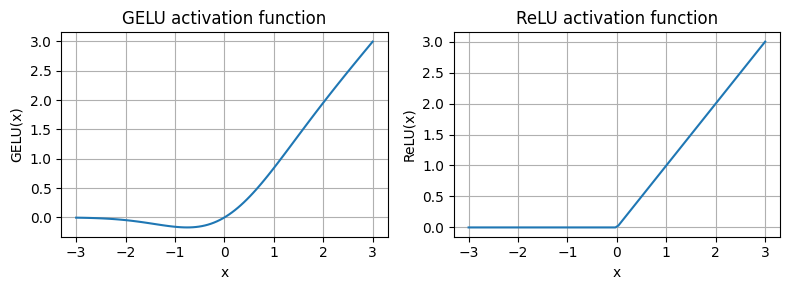

In [76]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    
plt.tight_layout()
plt.show()

- 正如我们所看到的,ReLU是一个分段线性函数,如果它是正的,则直接输出输入;否则，它输出零

- GELU是一个平滑的非线性函数,近似ReLU,但负值的梯度为非零

- 接下来,让我们实现一个小型神经网络模块FeedForward,稍后我们将在LLM的Transformer块中使用它：

In [77]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embedding_dim"], 4 * cfg["embedding_dim"]),
            GELU(),
            nn.Linear(cfg["embedding_dim"] * 4, cfg["embedding_dim"])
        )
        
    def forward(self, x):
        return self.layers(x)

In [78]:
print(GPT_CONFIG_124M["embedding_dim"])

768


![Alt text](../../img/LLM/ch03/FeedForward_process.png)

In [79]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


![Alt text](../../img/LLM/ch03/FeedForward_network.png)

![Alt text](../../img/LLM/ch03/ffn_of_LLM.png)

## 3.4 添加残差连接

- 接下来，让我们谈谈shortcut连接背后的概念，也称为残差连接
- 最初，在计算机视觉的深度网络（残差网络）中提出了shortcut连接，**以缓解消失梯度问题**
- shortcut连接为梯度在网络中流动创建了一个替代的较短路径
- 这是通过将一个层的输出添加到后一层的输出来实现的，通常跳过中间的一个或多个层
- 让我们用一个小的网络示例来说明这个想法：

![Alt text](../../img/LLM/ch03/resnet_network.png)

In [84]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), GELU()) for i in range(len(layer_sizes) - 1)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x
    

def print_gradients(model, x):
    output = model(x)
    tar = torch.tensor([[0.]])
    
    loss = nn.MSELoss()
    loss = loss(output, tar)
    
    loss.backward()
    
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 首先看一下没有残差连接的梯度值

In [88]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


- 再看一下有残差连接的梯度值

In [89]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


- 根据上面的输出，我们可以看到，残差连接可以防止梯度在早期层(layer.0)中消失
- 接下来，当我们实现Transformer块时，我们将使用shortcut连接的概念

## 3.5 Transformer块中的注意力和线性层

- 我们现在将前面的概念组合成一个transformer块
- transformer块将因果多头注意力模块与线性层相结合，线性层是我们之前实现的前馈神经网络
- 此外，transformer块还使用dropout和shortcut连接

In [91]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.d_in = cfg["embedding_dim"]
        self.d_out = cfg["embedding_dim"]
        self.context_length = cfg["context_length"]
        self.num_heads = cfg["n_heads"]
        self.dropout = cfg["drop_rate"]
        self.qkv_bias = cfg["qkv_bias"]
        
        self.attention = MultiHeadAttention(
            d_in=self.d_in,
            d_out=self.d_out,
            context_length=self.context_length,
            num_heads=self.num_heads,
            dropout=self.dropout,
            qkv_bias=self.qkv_bias
        )
        self.ffn = FeedForward(cfg)
        self.norm1 = LayerNorm(self.d_in)
        self.norm2 = LayerNorm(self.d_out)
        self.drop_shortcut = nn.Dropout(self.dropout)
        
    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

![Alt text](../../img/LLM/ch03/shortcut_of_LLM.png)

- 假设我们有2个输入样本，每个样本有6个标记，其中每个标记是768维的嵌入向量；然后这个Transformer块应用自注意，然后是线性层，以产生类似大小的输出

In [92]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {out.shape}")

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


![Alt text](../../img/LLM/ch03/Transformer_Block.png)

## 3.6 GPT模型代码编写

- 现在让我们将transformer块插入到我们在开头编码的体系结构中，以便获得可用的GPT体系结构
- 请注意，transformer块重复多次；在最小的124M GPT-2模型的情况下，我们重复它12次：

![Alt text](../../img/LLM/ch03/GPT_model.png)

In [94]:
import torch.nn as nn
import torch

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embedding_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embedding_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.transformer_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = LayerNorm(cfg["embedding_dim"])
        self.out_head = nn.Linear(
            cfg["embedding_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        token_embeddings = self.tok_emb(in_idx)
        pos_embeddings = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = token_embeddings + pos_embeddings
        x = self.drop_emb(x)
        x = self.transformer_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用124M参数模型的配置，我们现在可以实例化具有随机初始权重的GPT模型，如下所示：

In [96]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("Output shape:\n", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape:
 torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们之后训练此模型
- 然而，关于它的大小，请简要说明：我们之前将其称为124M参数模型；我们可以按如下方式对这个数字进行双重检查：

In [99]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 正如我们在上面看到的，这个模型有163M个参数，而不是124M个参数；为什么？
- 在GPT-2的原始论文中，研究人员应用了权重绑定，这意味着他们将token embedding层重新用作输出层，这意味着您将self.out_head.weight设置为self.tok_emb.weight
- token嵌入层将50257维token投影到768维嵌入表示
- 输出层将768个维度的嵌入投影回50257个维度的表示，这样我们就可以将这些embedding转换回单词（下一节将详细介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，正如我们根据其权重矩阵的形状所看到的
- 然而，关于它的大小，请简要说明：我们之前将其称为124M参数模型；我们可以按如下方式对这个数字进行双重检查：

In [98]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight trying: {total_params_gpt2:,}")

Number of trainable parameters considering weight trying: 124,412,160


## 3.7 生成文本

- 像我们上面实现的GPT模型这样的LLM用于一次生成一个单词

![Alt text](../../img/LLM/ch03/generate_text.png)

- 下面的generate_text_simple函数实现了贪婪解码，这是一种简单快速的生成文本的方法
- 在贪婪解码中，在每一步，模型都会选择具有最高概率的单词（或token）作为其下一个输出（最高logit对应于最高概率，因此从技术上讲，我们甚至不必显式计算softmax函数）
- 下图描述了给定输入上下文的GPT模型如何生成下一个单词标记

![Alt text](../../img/LLM/ch03/greedy_decoding.png)

In [100]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]
        
        probas = torch.softmax(logits, dim=-1)
        
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

- 上面的generate_text_simple实现了一个迭代过程，一次创建一个token

![Alt text](../../img/LLM/ch03/generate_text_example.png)

In [101]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print(f"encoded: {encoded}")

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print(f"encoded_tensor.shape: {encoded_tensor.shape}")

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [103]:
model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"output: {out}")
print(f"output shape: {out.shape}")

output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
output shape: torch.Size([1, 10])


In [104]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 由于模型未经训练，所以输出的是随机文本

# 四、预训练